In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "GPU-ff3v80879-d5b2-8469-da3d-71267d28a645"
from download_images import acquire_data
import rasterio as rio
import json
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Acquire Data

In [5]:
bounds = "map.geojson"

acquisition = acquire_data(geom_file=bounds, name="home", data_dir="home", date_range="2023-01-15/2023-08-10")
acquisition.download_l8()
acquisition.download_l8pan()
# acquisition.download_s2()

100%|██████████| 3/3 [00:06<00:00,  2.30s/it]


# Call Model

In [2]:
# Load model directly
from transformers import AutoModel
model = AutoModel.from_pretrained("venkatesh-thiru/s2l8h-UNet-5depth-upsample", trust_remote_code=True).cuda()
model.eval()

s2l8hModel(
  (model): AUNet(
    (encoding_module): ModuleList(
      (0): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(7, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): PReLU(num_parameters=1)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): PReLU(num_parameters=1)
        )
      )
      (1): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): PReLU(num_parameters=1)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): PReLU(num_parameters=1)
        )
      )
      (2): UNetConvBlock(
        (block): Sequential(
          (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): PReLU(num_parameters=1)
          (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): PReLU(num_parameters=1)
        

# Read Images

In [3]:
l8MS_path = "/data_fast/venkatesh/s2l8h_hf/Deep-Harmonization/inference/home/home/DN/L8/LC08_L2SP_143054_20230520_20230524_02_T1_SR.tif"
l8PAN_path = "/data_fast/venkatesh/s2l8h_hf/Deep-Harmonization/inference/home/home/DN/L8_pan/LC08_L1TP_143054_20230520_20230524_02_T1.tif"
l8_mtl_path = "/data_fast/venkatesh/s2l8h_hf/Deep-Harmonization/inference/home/home/DN/L8_pan/mtl/LC08_L1TP_143054_20230520_20230524_02_T1.json"

# Transform functions

In [4]:
def transform_l8ms(l8MS_path):
    raster = rio.open(l8MS_path, "r")
    print(raster)
    array = raster.read()
    array = array[:6]
    return array * 0.0000275 - 0.2

def transform_l8pan(l8PAN_path, l8_mtl_path):
    raster = rio.open(l8PAN_path, "r")
    array = raster.read()
    array = array[:6]
    meta = json.load(open(l8_mtl_path, "r"))

    meta = meta['LANDSAT_METADATA_FILE']['LEVEL1_RADIOMETRIC_RESCALING']
    return array * float(meta['REFLECTANCE_MULT_BAND_8'])+float(meta['REFLECTANCE_ADD_BAND_8'])


def extract_rgb(MS):
    MS = MS.detach().squeeze().cpu().numpy()
    MS = np.dstack([MS[2],MS[1],MS[0]])
    return MS

In [5]:
l8MS = torch.from_numpy(transform_l8ms(l8MS_path)).unsqueeze(dim=0).cuda()
l8MS = F.interpolate(l8MS, size=[l8MS.shape[-2]*3,l8MS.shape[-1]*3], mode="bicubic")

l8pan = torch.from_numpy(transform_l8pan(l8PAN_path, l8_mtl_path)).unsqueeze(dim = 0).cuda()
l8pan = F.interpolate(l8pan, size = l8MS.shape[2:], mode = "bicubic")

l8up = model(l8MS, l8pan)


<open DatasetReader name='/data_fast/venkatesh/s2l8h_hf/Deep-Harmonization/inference/home/home/DN/L8/LC08_L2SP_143054_20230520_20230524_02_T1_SR.tif' mode='r'>


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


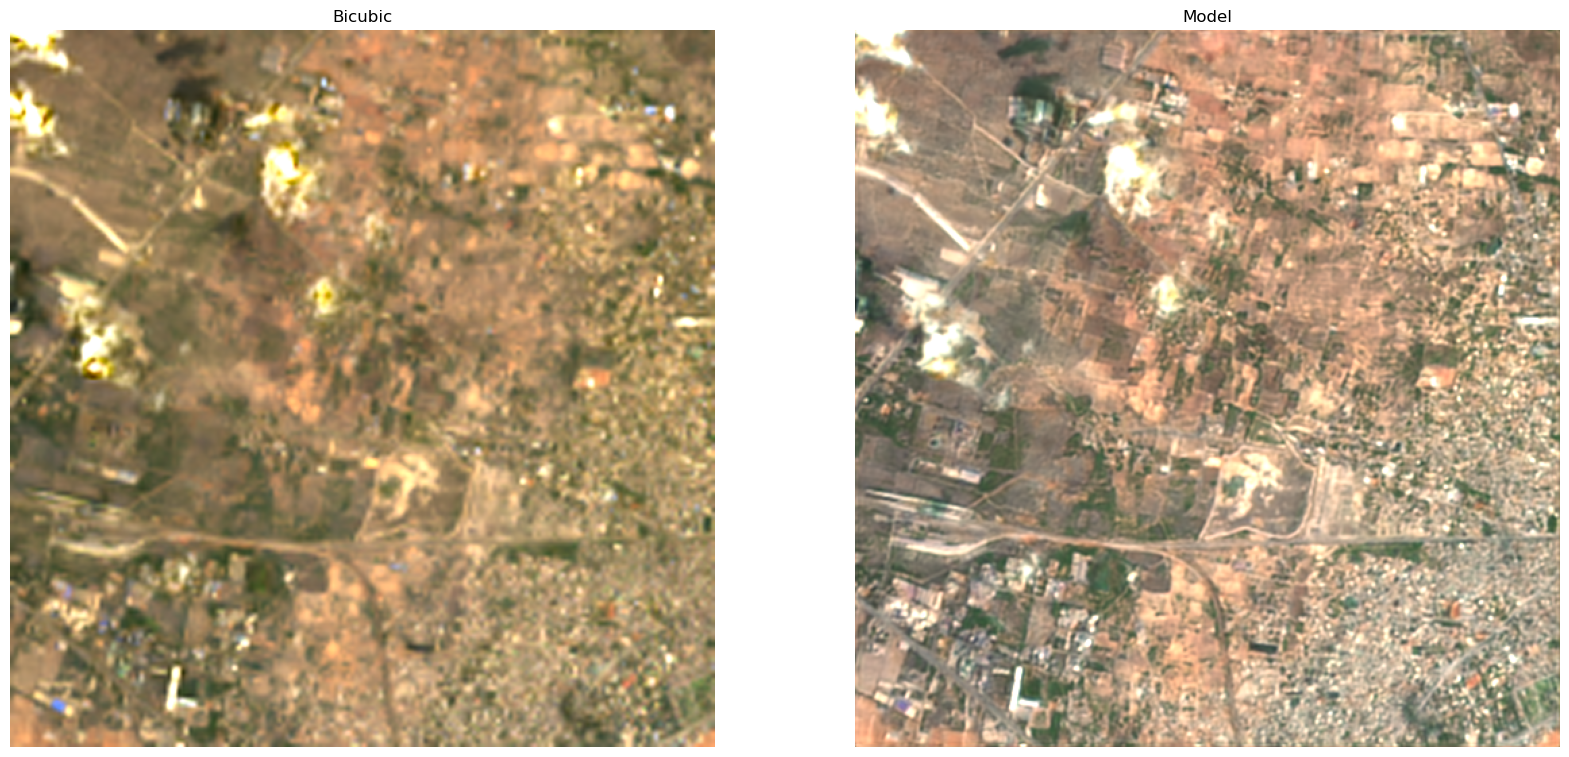

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (20, 10))

ax[0].imshow(extract_rgb(l8MS*5))
ax[0].set_axis_off()
ax[0].set_title("Bicubic")
ax[1].imshow(extract_rgb(l8up*5))
ax[1].set_axis_off()
ax[1].set_title("Model")
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


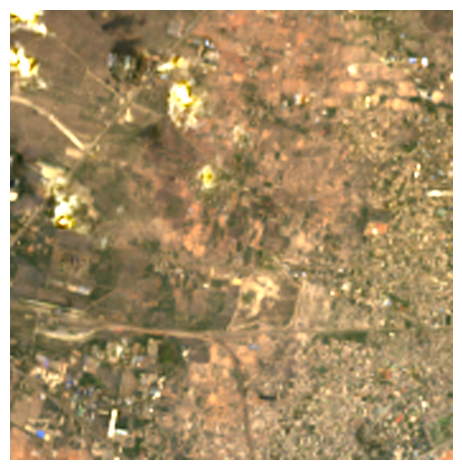

In [13]:
plt.imshow(extract_rgb(l8MS*5))
plt.axis("off")
plt.tight_layout()
plt.savefig("bicubic.jpg")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


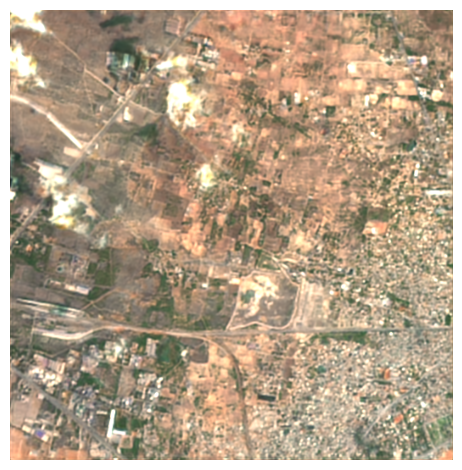

In [14]:
plt.imshow(extract_rgb(l8up*5))
plt.axis("off")
plt.tight_layout()
plt.savefig("model.jpg")


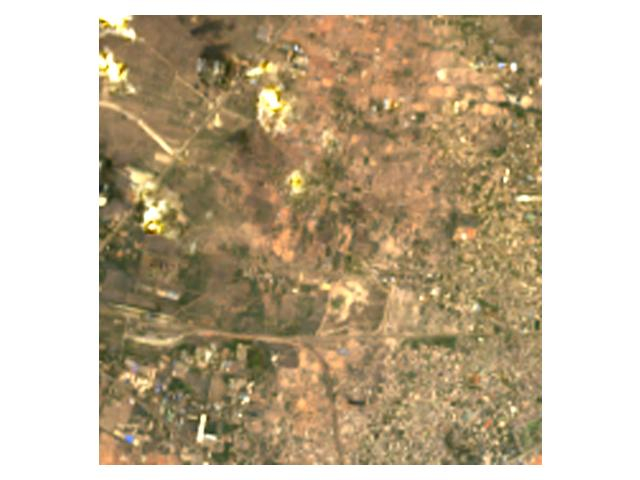
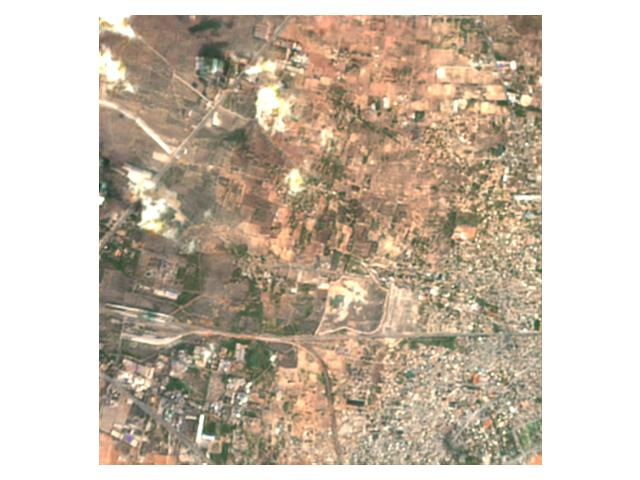

In [17]:
import leafmap



leafmap.image_comparison(img1 = "bicubic.jpg", img2="model.jpg",    label1='Bicubic',
    label2='Model',
    starting_position=50,
    )